# 코랩 연결

In [ ]:
# google drive와 colab연동
from google.colab import auth

auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 함수호출

In [ ]:
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tqdm import tnrange, tqdm_notebook
from statsmodels.regression.quantile_regression import QuantReg


from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, LSTM, TimeDistributed,Bidirectional, GRU, Dropout
from keras.optimizers import Adam
import keras.backend as K
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 씨드 고정

In [ ]:
def random_seed_fix(seed_num=42):
  np.random.seed(seed_num)
  random.seed(seed_num)
  tf.compat.v1.set_random_seed(seed_num)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

random_seed_fix(seed_num=42)

# 데이터 불러오기

In [ ]:
path = "./gdrive/My Drive/dacon/발전량/data/"

train_df = pd.read_csv(path+'./train/train.csv')
sub_df = pd.read_csv(path+'./sample_submission.csv')

test_df = pd.DataFrame()
test_set_df = pd.DataFrame()

for i in tqdm(os.listdir(path+'/test/')):
  df = pd.read_csv(path+"/test/"+i)
  df["F_NAME"] = "TEST_"+i
  test_df = pd.concat([test_df,df],axis=0)
  test_set_df = pd.concat([test_set_df,df[(df["Day"]>=5)]],axis=0)

  del df

test_df["TY"] = test_df["F_NAME"].apply(lambda x:x[x.find("_")+1:x.find(".")])
test_df["TY"] = test_df["TY"].astype('int')
test_df.sort_values(by=["TY","Day","Hour","Minute"],inplace=True)
test_df = test_df.reset_index(drop=True) 

test_set_df = test_set_df.reset_index(drop=True)
test_set_df["TY"] = test_set_df["F_NAME"].apply(lambda x:x[x.find("_")+1:x.find(".")])
test_set_df["TY"] = test_set_df["TY"].astype('int')
test_set_df.sort_values(by=["TY","Day","Hour","Minute"],inplace=True)
test_set_df = test_set_df.reset_index(drop=True) 

100%|██████████| 81/81 [00:12<00:00,  6.36it/s]


In [ ]:
print(train_df.shape)
train_df.head()

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [ ]:
print("Test Data의 종류는 총 {}개".format(len(test_df['F_NAME'].unique())))
print(test_df.shape)
test_df.head()

Test Data의 종류는 총 81개
(27216, 11)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,F_NAME,TY
0,0,0,0,0,0,2.7,34.42,0.0,0.0,TEST_0.csv,0
1,0,0,30,0,0,2.7,34.17,0.1,0.0,TEST_0.csv,0
2,0,1,0,0,0,2.7,34.23,0.2,0.0,TEST_0.csv,0
3,0,1,30,0,0,2.7,33.99,0.3,0.0,TEST_0.csv,0
4,0,2,0,0,0,2.8,33.97,0.4,0.0,TEST_0.csv,0


# train data 살펴보기

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Day,52560.0,547.000000,316.102148,0.00,273.0000,547.0,821.00000,1094.000000
Hour,52560.0,11.500000,6.922252,0.00,5.7500,11.5,17.25000,23.000000
Minute,52560.0,15.000000,15.000143,0.00,0.0000,15.0,30.00000,30.000000
DHI,52560.0,64.344121,103.897125,0.00,0.0000,0.0,87.00000,528.000000
DNI,52560.0,234.792371,349.684583,0.00,0.0000,0.0,469.00000,1059.000000
WS,52560.0,2.456033,1.426874,0.00,1.4000,2.2,3.20000,12.000000
RH,52560.0,56.793102,22.052875,7.59,39.6975,57.6,72.77000,100.000000
T,52560.0,9.279928,10.179741,-19.00,1.0000,9.0,17.00000,35.000000
TARGET,52560.0,17.790630,25.759955,0.00,0.0000,0.0,32.08989,99.913939


In [ ]:
train_df.isnull().sum()

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

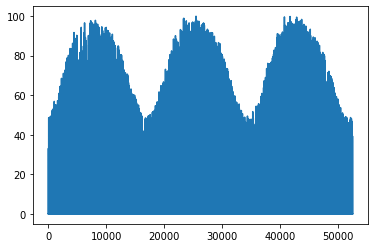

In [ ]:
# 데이터 추세 동일
train_df["TARGET"].plot()

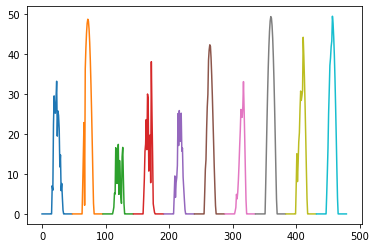

In [ ]:
for i in range(0,10):
  train_df[train_df["Day"]==i]['TARGET'].plot()

In [ ]:
t_max_df = train_df.groupby(["Day"])["TARGET"].max().reset_index()
t_max_df.head()

,Day,TARGET
0,0,33.129393
1,1,48.612666
2,2,17.361857
3,3,38.008390
4,4,25.806465


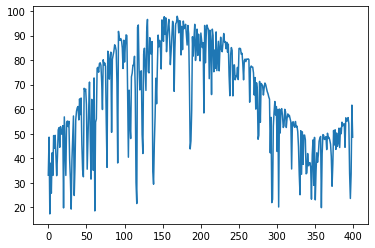

In [ ]:
t_max_df[t_max_df["Day"]<400]["TARGET"].plot()

In [ ]:
t_max_df.shape[0]/3

365.0

# Train Data 2년 Valid 1년 사용

0.0
99.91393869


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


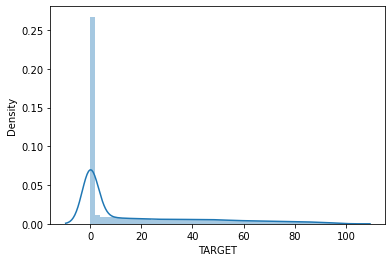

In [ ]:
print(train_df[train_df["Day"] <= (365*2)]["TARGET"].min())
print(train_df[train_df["Day"] <= (365*2)]["TARGET"].max())
sns.distplot(train_df[train_df["Day"] <= (365*2)]["TARGET"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


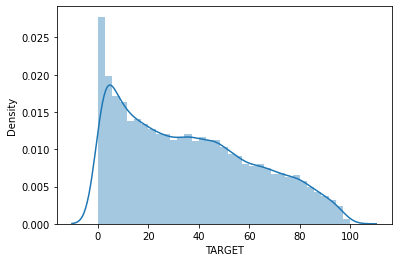

In [ ]:
sns.distplot(train_df[train_df["TARGET"]!=0]['TARGET'])

In [ ]:
train_df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


# Features Engineearing

## 1.변수 만들기

In [ ]:
def agg_mean(df, agg_col, target_col):
  #agg_col = ["Day","Hour"]
  #target_col = [i for i in list(train_df.columns) if i not in agg_col +["Minute"]]

  agg_df = df.groupby(agg_col)[target_col].mean().reset_index()
  
  col_new_dict = {}

  for i in target_col:
    new_col_name = "mean_"+i
    col_new_dict[i] = new_col_name
  
  agg_df.rename(col_new_dict,axis='columns',inplace=True)

  return pd.merge(df,agg_df,on=agg_col,how="left")

def time_dummies1(df,time_col):
  
  # time_col = ["Hour","Minute"]
  time_df = pd.DataFrame(df[time_col[0]] * 60 + df[time_col[1]])
  time_df.columns = ["ALL_Minute"]
  time_df["ALL_Minute"] = time_df["ALL_Minute"].astype('category')
  
  return pd.concat([df,pd.get_dummies(time_df)],axis=1)

def time_dummies2(df):

  m1 = [1,2,3,4,5,6]
  m2 = [7,8,9,10,11,12]
  m3 = [13,14,15,16,17,18]
  m4 = [19,20,21,22,23,0]

  df_fe = df.copy()

  df_fe.loc[df["Hour"].isin(m1),"Hour_dummies"] = "m1"
  df_fe.loc[df["Hour"].isin(m2),"Hour_dummies"] = "m2"
  df_fe.loc[df["Hour"].isin(m3),"Hour_dummies"] = "m3"
  df_fe.loc[df["Hour"].isin(m4),"Hour_dummies"] = "m4"

  return pd.concat([df,pd.get_dummies(df_fe["Hour_dummies"])],axis=1)

def rolling_mean(df,time_col,weather_col,rolling):
  # time_col = ["Day","Hour"]
  # weather_col = ["DHI","DNI","WS","RH","T","TARGET"]
  # rolling = [6,12,18,24]
  agg_df = df.groupby(time_col)[weather_col].mean().reset_index()
  agg_min_df = df.groupby(time_col)[weather_col].min().reset_index()
  agg_max_df = df.groupby(time_col)[weather_col].max().reset_index()

  rolling_all_df = agg_df[time_col].copy()


  for i in range(len(rolling)):
    
    # df
    rolling_df = agg_df[weather_col].rolling(rolling[i]).mean().fillna(method="ffill").fillna(method="bfill")
    rolling_min_df = agg_min_df[weather_col].rolling(rolling[i]).min().fillna(method="ffill").fillna(method="bfill")
    rolling_max_df = agg_max_df[weather_col].rolling(rolling[i]).min().fillna(method="ffill").fillna(method="bfill")
    rolling_diff_df = rolling_max_df - rolling_min_df
    
    new_col1 = {}
    new_col2 = {}
    new_col3 = {}
    new_col4 = {}

    for j in rolling_df.columns:
      new_col1[j] = j+"_rolling_{}".format(str(rolling[i]))

    rolling_df.rename(new_col1,axis='columns',inplace=True)

    for j in rolling_min_df.columns:
      new_col2[j] = j+"_rolling_min_{}".format(str(rolling[i]))

    rolling_min_df.rename(new_col2,axis='columns',inplace=True)

    for j in rolling_max_df.columns:
      new_col3[j] = j+"_rolling_max_{}".format(str(rolling[i]))

    rolling_max_df.rename(new_col3,axis='columns',inplace=True)

    for j in rolling_diff_df.columns:
      new_col4[j] = j+"_rolling_diff_{}".format(str(rolling[i]))

    rolling_diff_df.rename(new_col4,axis='columns',inplace=True)


    rolling_all_df = pd.concat([rolling_all_df,rolling_df],axis="columns")
    rolling_all_df = pd.concat([rolling_all_df,rolling_min_df],axis="columns")
    rolling_all_df = pd.concat([rolling_all_df,rolling_max_df],axis="columns")
    rolling_all_df = pd.concat([rolling_all_df,rolling_diff_df],axis="columns")

  return pd.merge(df,rolling_all_df,on=time_col,how="left")

In [ ]:
agg_col = ["Day","Hour"]
target_col = [i for i in list(train_df.columns) if i not in agg_col +["Minute"]]
time_col = ["Hour","Minute"]
time_col1 = ["Day","Hour"]
weather_col = ["DHI","DNI","WS","RH","T","TARGET"]
rolling = [6,12,18,24]

#train_df_fe = agg_mean(train_df,agg_col,target_col)

train_df_fe = time_dummies1(train_df,time_col)
train_df_fe = time_dummies2(train_df_fe)
train_df_fe = rolling_mean(train_df_fe,time_col1,weather_col,rolling)

#test_df_fe = agg_mean(test_df,agg_col,target_col)

test_df_fe = time_dummies1(test_df,time_col)
test_df_fe = time_dummies2(test_df_fe)
test_df_fe = rolling_mean(test_df_fe,time_col1,weather_col,rolling)

# 하루 삭제
train_df_fe = train_df_fe[train_df_fe["Day"] != 0].reset_index(drop=True)
# 최근 2일 외 데이터 삭제
test_df_fe = test_df_fe[(test_df_fe["Day"] == 5) | (test_df_fe["Day"] == 6)].reset_index(drop=True)

train_df_fe.drop(["Day","Hour","Minute"],axis=1, inplace=True)
test_df_fe.drop(["Day","Hour","Minute","F_NAME","TY"],axis=1, inplace=True)

##2.스케일링

In [ ]:
scale_col = []

for i in train_df_fe.columns:
  if  i != "TARGET" and i.startswith("ALL_Minute") == False:
    scale_col.append(i)

# min_max scaler 사용
scaler_target = MinMaxScaler()
scaler_all = MinMaxScaler()

scaler_target.fit(train_df_fe[["TARGET"]])
scaler_all.fit(train_df_fe[scale_col])

train_df_fe[["TARGET"]] = scaler_target.transform(train_df_fe[["TARGET"]])
test_df_fe[["TARGET"]] = scaler_target.transform(test_df_fe[["TARGET"]])

train_df_fe[scale_col] =  scaler_all.transform(train_df_fe[scale_col])
test_df_fe[scale_col] =  scaler_all.transform(test_df_fe[scale_col])

In [ ]:
print(train_df_fe.shape)
train_df_fe.head()

(52512, 154)


,DHI,DNI,WS,RH,T,TARGET,ALL_Minute_0,ALL_Minute_30,ALL_Minute_60,ALL_Minute_90,ALL_Minute_120,ALL_Minute_150,ALL_Minute_180,ALL_Minute_210,ALL_Minute_240,ALL_Minute_270,ALL_Minute_300,ALL_Minute_330,ALL_Minute_360,ALL_Minute_390,ALL_Minute_420,ALL_Minute_450,ALL_Minute_480,ALL_Minute_510,ALL_Minute_540,ALL_Minute_570,ALL_Minute_600,ALL_Minute_630,ALL_Minute_660,ALL_Minute_690,ALL_Minute_720,ALL_Minute_750,ALL_Minute_780,ALL_Minute_810,ALL_Minute_840,ALL_Minute_870,ALL_Minute_900,ALL_Minute_930,ALL_Minute_960,ALL_Minute_990,...,WS_rolling_min_18,RH_rolling_min_18,T_rolling_min_18,TARGET_rolling_min_18,DHI_rolling_max_18,DNI_rolling_max_18,WS_rolling_max_18,RH_rolling_max_18,T_rolling_max_18,TARGET_rolling_max_18,DHI_rolling_diff_18,DNI_rolling_diff_18,WS_rolling_diff_18,RH_rolling_diff_18,T_rolling_diff_18,TARGET_rolling_diff_18,DHI_rolling_24,DNI_rolling_24,WS_rolling_24,RH_rolling_24,T_rolling_24,TARGET_rolling_24,DHI_rolling_min_24,DNI_rolling_min_24,WS_rolling_min_24,RH_rolling_min_24,T_rolling_min_24,TARGET_rolling_min_24,DHI_rolling_max_24,DNI_rolling_max_24,WS_rolling_max_24,RH_rolling_max_24,T_rolling_max_24,TARGET_rolling_max_24,DHI_rolling_diff_24,DNI_rolling_diff_24,WS_rolling_diff_24,RH_rolling_diff_24,T_rolling_diff_24,TARGET_rolling_diff_24
0,0.0,0.0,0.133333,0.898929,0.166667,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.229508,0.563652,0.184211,0.0,0.0,0.0,0.230769,0.557283,0.210526,0.0,0.0,0.0,0.095238,0.210682,0.666667,0.0,0.201607,0.150452,0.192850,0.668475,0.161074,0.132303,0.0,0.0,0.265306,0.586811,0.189189,0.0,0.0,0.0,0.25,0.607506,0.166667,0.0,0.0,0.0,0.0,0.210682,0.0,0.0
1,0.0,0.0,0.133333,0.899145,0.166667,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.229508,0.563652,0.184211,0.0,0.0,0.0,0.230769,0.557283,0.210526,0.0,0.0,0.0,0.095238,0.210682,0.666667,0.0,0.201607,0.150452,0.192850,0.668475,0.161074,0.132303,0.0,0.0,0.265306,0.586811,0.189189,0.0,0.0,0.0,0.25,0.607506,0.166667,0.0,0.0,0.0,0.0,0.210682,0.0,0.0
2,0.0,0.0,0.133333,0.871334,0.148148,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.262295,0.563652,0.210526,0.0,0.0,0.0,0.230769,0.557283,0.184211,0.0,0.0,0.0,0.000000,0.210682,0.000000,0.0,0.201607,0.150452,0.192850,0.677900,0.162106,0.132303,0.0,0.0,0.265306,0.586811,0.189189,0.0,0.0,0.0,0.25,0.607506,0.166667,0.0,0.0,0.0,0.0,0.210682,0.0,0.0
3,0.0,0.0,0.133333,0.871334,0.148148,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.262295,0.563652,0.210526,0.0,0.0,0.0,0.230769,0.557283,0.184211,0.0,0.0,0.0,0.000000,0.210682,0.000000,0.0,0.201607,0.150452,0.192850,0.677900,0.162106,0.132303,0.0,0.0,0.265306,0.586811,0.189189,0.0,0.0,0.0,0.25,0.607506,0.166667,0.0,0.0,0.0,0.0,0.210682,0.0,0.0
4,0.0,0.0,0.133333,0.900985,0.148148,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.262295,0.563652,0.210526,0.0,0.0,0.0,0.230769,0.557283,0.184211,0.0,0.0,0.0,0.000000,0.210682,0.000000,0.0,0.201607,0.150452,0.193164,0.688624,0.162623,0.132303,0.0,0.0,0.265306,0.586811,0.189189,0.0,0.0,0.0,0.25,0.607506,0.166667,0.0,0.0,0.0,0.0,0.210682,0.0,0.0


In [ ]:
print(test_df_fe.shape)
test_df_fe.head()

(7776, 154)


,DHI,DNI,WS,RH,T,TARGET,ALL_Minute_0,ALL_Minute_30,ALL_Minute_60,ALL_Minute_90,ALL_Minute_120,ALL_Minute_150,ALL_Minute_180,ALL_Minute_210,ALL_Minute_240,ALL_Minute_270,ALL_Minute_300,ALL_Minute_330,ALL_Minute_360,ALL_Minute_390,ALL_Minute_420,ALL_Minute_450,ALL_Minute_480,ALL_Minute_510,ALL_Minute_540,ALL_Minute_570,ALL_Minute_600,ALL_Minute_630,ALL_Minute_660,ALL_Minute_690,ALL_Minute_720,ALL_Minute_750,ALL_Minute_780,ALL_Minute_810,ALL_Minute_840,ALL_Minute_870,ALL_Minute_900,ALL_Minute_930,ALL_Minute_960,ALL_Minute_990,...,WS_rolling_min_18,RH_rolling_min_18,T_rolling_min_18,TARGET_rolling_min_18,DHI_rolling_max_18,DNI_rolling_max_18,WS_rolling_max_18,RH_rolling_max_18,T_rolling_max_18,TARGET_rolling_max_18,DHI_rolling_diff_18,DNI_rolling_diff_18,WS_rolling_diff_18,RH_rolling_diff_18,T_rolling_diff_18,TARGET_rolling_diff_18,DHI_rolling_24,DNI_rolling_24,WS_rolling_24,RH_rolling_24,T_rolling_24,TARGET_rolling_24,DHI_rolling_min_24,DNI_rolling_min_24,WS_rolling_min_24,RH_rolling_min_24,T_rolling_min_24,TARGET_rolling_min_24,DHI_rolling_max_24,DNI_rolling_max_24,WS_rolling_max_24,RH_rolling_max_24,T_rolling_max_24,TARGET_rolling_max_24,DHI_rolling_diff_24,DNI_rolling_diff_24,WS_rolling_diff_24,RH_rolling_diff_24,T_rolling_diff_24,TARGET_rolling_diff_24
0,0.0,0.0,0.175000,0.489557,0.270370,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.016393,-0.017939,0.089474,0.0,0.0,0.0,0.892308,0.741739,0.978947,0.0,0.0,0.0,2.761905,4.886499,11.600000,0.0,0.297064,0.45149,0.246747,0.344219,0.592382,0.449976,0.0,0.0,0.020408,-0.018676,0.091892,0.0,0.0,0.0,0.979167,0.808585,1.025,0.0,0.0,0.0,3.615385,4.886499,11.5,0.0
1,0.0,0.0,0.166667,0.506980,0.262963,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.016393,-0.017939,0.089474,0.0,0.0,0.0,0.892308,0.741739,0.978947,0.0,0.0,0.0,2.761905,4.886499,11.600000,0.0,0.297064,0.45149,0.246747,0.344219,0.592382,0.449976,0.0,0.0,0.020408,-0.018676,0.091892,0.0,0.0,0.0,0.979167,0.808585,1.025,0.0,0.0,0.0,3.615385,4.886499,11.5,0.0
2,0.0,0.0,0.158333,0.489016,0.257407,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.016393,-0.017939,0.089474,0.0,0.0,0.0,0.892308,0.741739,0.973684,0.0,0.0,0.0,2.761905,4.886499,11.533333,0.0,0.297064,0.45149,0.246445,0.344260,0.591803,0.449976,0.0,0.0,0.020408,-0.018676,0.091892,0.0,0.0,0.0,0.979167,0.808585,1.025,0.0,0.0,0.0,3.615385,4.886499,11.5,0.0
3,0.0,0.0,0.150000,0.497782,0.253704,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.016393,-0.017939,0.089474,0.0,0.0,0.0,0.892308,0.741739,0.973684,0.0,0.0,0.0,2.761905,4.886499,11.533333,0.0,0.297064,0.45149,0.246445,0.344260,0.591803,0.449976,0.0,0.0,0.020408,-0.018676,0.091892,0.0,0.0,0.0,0.979167,0.808585,1.025,0.0,0.0,0.0,3.615385,4.886499,11.5,0.0
4,0.0,0.0,0.141667,0.487393,0.250000,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.016393,-0.017939,0.089474,0.0,0.0,0.0,0.892308,0.741739,0.971053,0.0,0.0,0.0,2.761905,4.886499,11.500000,0.0,0.297064,0.45149,0.245981,0.344292,0.591299,0.449976,0.0,0.0,0.020408,-0.018676,0.091892,0.0,0.0,0.0,0.979167,0.808585,1.025,0.0,0.0,0.0,3.615385,4.886499,11.5,0.0


##3.데이터 분할

In [ ]:
test_x = []

for i in np.arange(0,test_df_fe.shape[0],test_df_fe.shape[0]//81):
  test_x.append(test_df_fe.iloc[i:i+96,:])

test_x = np.array(test_x)

In [ ]:
def sampling(data,day,size):

  train_x = []
  train_y = []

  x_start = 0
  y_start = day*size

  while y_start < len(data)-(day*size):

    train_x.append(data[x_start : x_start + (day*size),:])
    train_y.append(data[y_start : y_start + (day*size),5])

    x_start += (day)
    y_start += (day)

  return np.array(train_x), np.array(train_y).reshape(-1,96,1)

In [ ]:
def sampling_shift(df, seq_length, label_length):
  x = []
  y = []

  for i in tqdm(range(len(df)-seq_length-label_length)):
    _x = df.iloc[i : i+seq_length, :]
    _y = df.iloc[i+seq_length : i+seq_length+label_length,5]
    
    x.append(_x)
    y.append(_y)

  return x,y

In [ ]:
seq_length = 24*2*2
label_length = 24*2*2

x, y = sampling_shift(train_df_fe,seq_length,label_length)

100%|██████████| 52320/52320 [00:10<00:00, 5149.44it/s]


In [ ]:
#x, y = sampling(train_df_fe.values,48,2)

## 4.샘플링

In [ ]:
train_x,valid_x,train_y,valid_y = train_test_split(x,y,test_size=0.3,random_state=42,shuffle=False)

In [ ]:
del x, y, train_df, train_df_fe

In [ ]:
train_x = np.array(train_x)
valid_x = np.array(valid_x)
train_y = np.array(train_y).reshape(-1,96,1)
valid_y = np.array(valid_y).reshape(-1,96,1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

print(train_y.shape)
print(valid_y.shape)

##4-1. 학습 데이터 만들기

In [ ]:
train_x = np.array(x)
train_y = np.array(y).reshape(-1,96,1)

In [ ]:
print(train_x.shape)
print(train_y.shape)

print(test_x.shape)

(52320, 96, 154)
(52320, 96, 1)
(81, 96, 154)


In [ ]:
del x,y, train_df, train_df_fe, test_df, test_df_fe, test_x

##5.모델링

In [ ]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def base_model():

  time_input = Input(batch_shape=(None, 96, 60))
  lstm_layer1 = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(time_input)
  lstm_layer2 = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(lstm_layer1)
  layer1 = TimeDistributed(Dense(64))(lstm_layer2)
  layer2 = TimeDistributed(Dense(32))(layer1)
  time_output = TimeDistributed(Dense(1))(layer2)
  model = Model(time_input, time_output)
  
  return model


def base_model2():

  time_input = Input(batch_shape=(None, 96, 60))
  lstm_layer1 = Bidirectional(LSTM(256, dropout=0.25, return_sequences=True))(time_input)
  lstm_layer2 = Bidirectional(LSTM(256, dropout=0.25, return_sequences=True))(lstm_layer1)
  layer1 = TimeDistributed(Dense(128))(lstm_layer2)
  layer2 = TimeDistributed(Dense(64))(layer1)
  layer3 = TimeDistributed(Dense(32))(layer2)
  time_output = TimeDistributed(Dense(1))(layer3)
  model = Model(time_input, time_output)
  
  return model


def base_model3():

  time_input = Input(batch_shape=(None, 96, 154))
  lstm_layer1 = Bidirectional(LSTM(256, dropout=0.1, return_sequences=True), merge_mode = 'concat')(time_input)
  lstm_layer2 = Bidirectional(LSTM(512, dropout=0.1, return_sequences=True), merge_mode = 'concat')(lstm_layer1)
  #lstm_layer3 = Bidirectional(LSTM(512, dropout=0.35, return_sequences=True), merge_mode = 'concat')(lstm_layer2) , recurrent_dropout=0.15 recurrent_dropout=0.15,
  layer1 = TimeDistributed(Dense(1024))(lstm_layer2)
  layer2 = TimeDistributed(Dense(512))(layer1)
  layer3 = TimeDistributed(Dense(256))(layer2)
  layer4 = TimeDistributed(Dense(64))(layer3)
  time_output = TimeDistributed(Dense(1))(layer4)
  model = Model(time_input, time_output)
  
  return model

##6.모델평가

In [ ]:
# 씨드 고정
random_seed_fix(seed_num=42)

# 최적화 방법 수정
ada_delta = tf.keras.optimizers.Adadelta(learning_rate=0.018, rho=0.95, epsilon=1e-07, name='Adadelta',)

qs = [i/10 for i in range(1,10)]
history_dict = {}

for q in qs:
  if q >= 0.9:

    print("q = {}의 학습이 시작됨".format(q))
    #model = base_model2()
    model = base_model3()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=ada_delta,metrics=['mae'])
    history = model.fit(train_x, train_y, epochs=100, batch_size=256, verbose=1)
    history_dict[q] = history.history
    print("q = {}의 학습이 종료됨\n\n".format(q))
    model.save(path+'lstm_train_model_{}.h5'.format(q))
    #pd.DataFrame(history_dict[q]).to_csv(path+'lstm_model_{}_valid.csv'.format(q),index=False)
    #time.sleep(600)

  else:
    continue

q = 0.9의 학습이 시작됨
Epoch 1/100
205/205 [==============================] - 82s 342ms/step - loss: 0.0342 - mae: 0.2247
Epoch 2/100
205/205 [==============================] - 70s 340ms/step - loss: 0.0219 - mae: 0.1702
Epoch 3/100
205/205 [==============================] - 70s 340ms/step - loss: 0.0198 - mae: 0.1540
Epoch 4/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0187 - mae: 0.1478
Epoch 5/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0176 - mae: 0.1376
Epoch 6/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0169 - mae: 0.1336
Epoch 7/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0163 - mae: 0.1289
Epoch 8/100
205/205 [==============================] - 70s 341ms/step - loss: 0.0158 - mae: 0.1253
Epoch 9/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0156 - mae: 0.1234
Epoch 10/100
205/205 [==============================] - 70s 342ms/step - loss: 0.0152 - mae:

In [ ]:
#0.1736
check_df = pd.DataFrame()

for i in history_dict.keys():
  stack = pd.DataFrame(history_dict[i])
  stack = stack.reset_index()
  stack.index = [i for k in range(stack.shape[0])]
  check_df = pd.concat([check_df,stack],axis=0)

In [ ]:
check_df.to_csv("valid2.csv",index=False,encoding='utf-8')

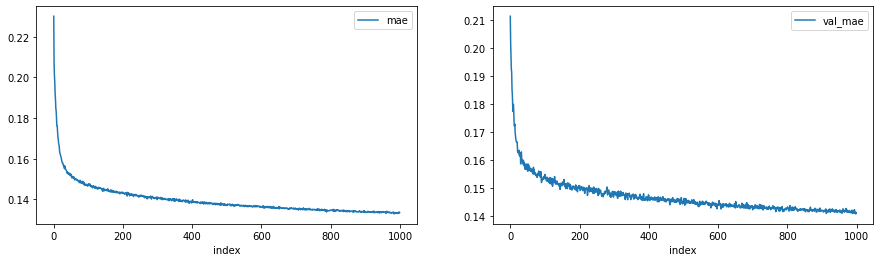

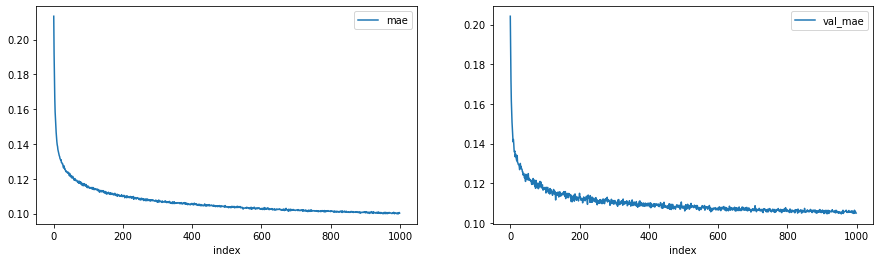

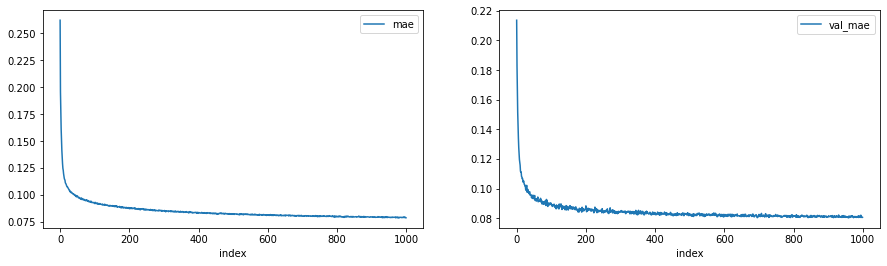

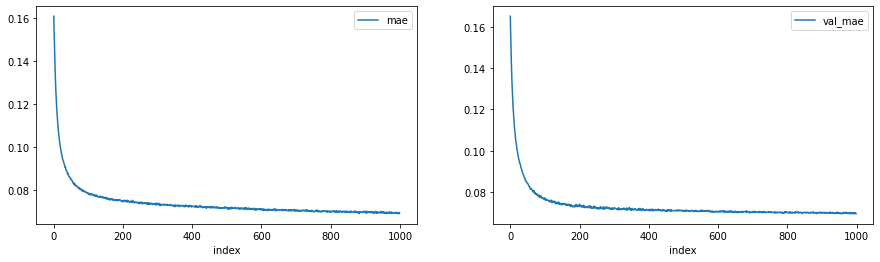

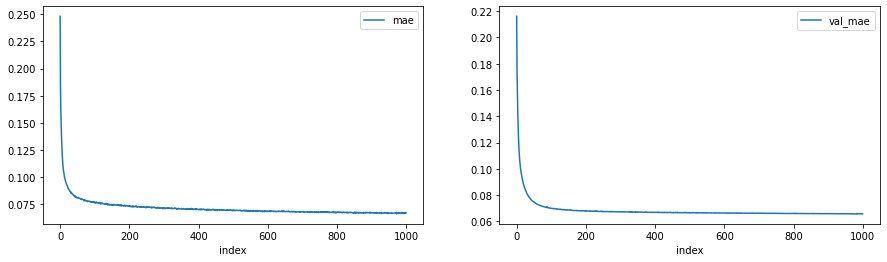

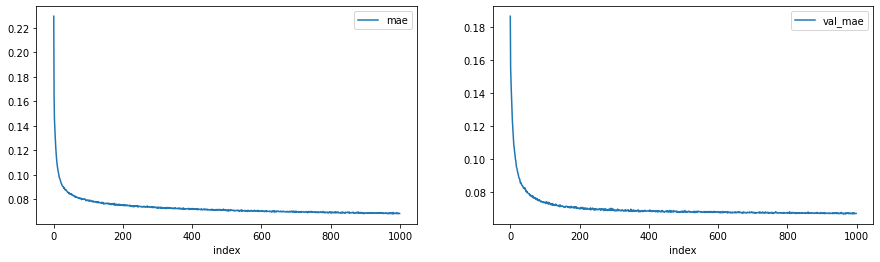

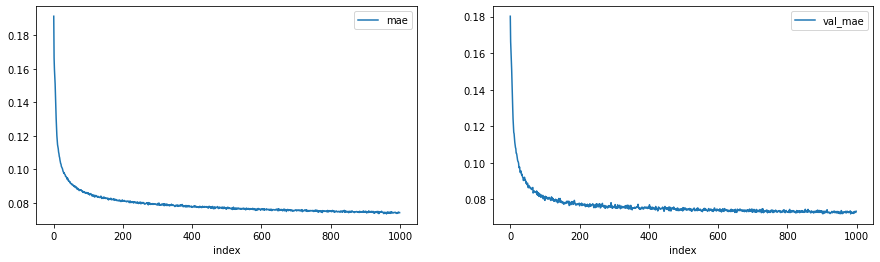

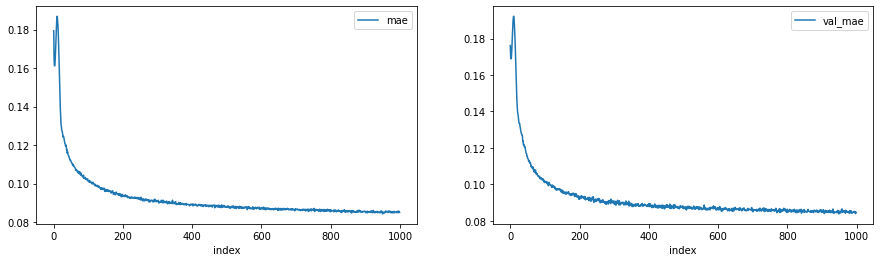

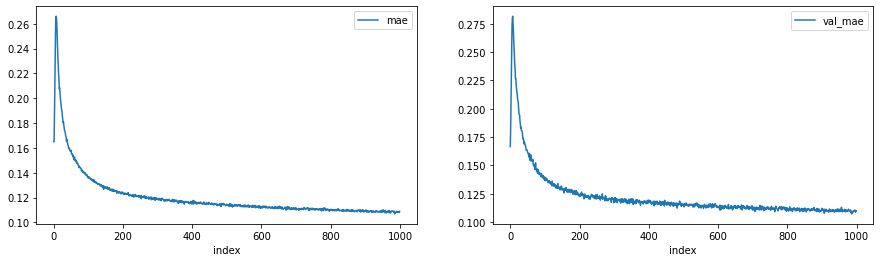

In [ ]:
for i in range(1,10):
  plt.figure(figsize=(15,4))
  plt.title("{}번째 그래프".format(i/10))
  check_df.loc[i/10,["index","loss","mae","val_mae"]].plot(x="index",y=["mae"],ax=plt.subplot(121))
  check_df.loc[i/10,["index","loss","mae","val_mae"]].plot(x="index",y="val_mae",ax=plt.subplot(122))
  plt.show()

In [ ]:
check_df=check_df.reset_index()
check_df.head()

,level_0,index,loss,mae,val_loss,val_mae
0,0.1,0,0.024105,0.230153,0.022286,0.211343
1,0.1,1,0.022766,0.206739,0.021642,0.202043
2,0.1,2,0.022402,0.200990,0.021115,0.196893
3,0.1,3,0.021982,0.197623,0.020653,0.192572
4,0.1,4,0.021479,0.191966,0.020295,0.191419


In [ ]:
check_df[check_df['index']==499]

,level_0,index,loss,mae,val_loss,val_mae
499,0.1,499,0.016091,0.137423,0.016715,0.144708
1499,0.2,499,0.026719,0.103933,0.027146,0.107475
2499,0.3,499,0.032703,0.082509,0.032310,0.081863
3499,0.4,499,0.034816,0.072016,0.034248,0.070614
4499,0.5,499,0.034453,0.068906,0.033271,0.066541
5499,0.6,499,0.032321,0.070916,0.030592,0.068155
6499,0.7,499,0.028208,0.076302,0.026819,0.075518
7499,0.8,499,0.022436,0.087812,0.021284,0.088037
8499,0.9,499,0.014464,0.114420,0.013448,0.114678


In [ ]:
check_df[check_df['index']==99]

,level_0,index,loss,mae,val_loss,val_mae
99,0.1,99,0.017407,0.146950,0.017542,0.154447
1099,0.2,99,0.029475,0.115261,0.028880,0.117493
2099,0.3,99,0.035956,0.091938,0.034481,0.090166
3099,0.4,99,0.037388,0.078464,0.036433,0.077069
4099,0.5,99,0.038656,0.077313,0.035000,0.070001
5099,0.6,99,0.036234,0.078961,0.033298,0.073554
6099,0.7,99,0.031999,0.085568,0.029179,0.080841
7099,0.8,99,0.025983,0.101362,0.024942,0.101790
8099,0.9,99,0.017187,0.135818,0.015820,0.139346


In [ ]:
check_df[check_df['index']==999]

,level_0,index,loss,mae,val_loss,val_mae
999,0.1,999,0.015484,0.133468,0.016348,0.141357
1999,0.2,999,0.025711,0.100253,0.026678,0.104955
2999,0.3,999,0.031278,0.078706,0.031877,0.080592
3999,0.4,999,0.033777,0.069569,0.033813,0.069613
4999,0.5,999,0.033606,0.067211,0.032855,0.065710
5999,0.6,999,0.031204,0.068613,0.030101,0.066771
6999,0.7,999,0.027295,0.074240,0.026219,0.073541
7999,0.8,999,0.021582,0.085024,0.020642,0.084497
8999,0.9,999,0.013754,0.108786,0.012968,0.110038


In [ ]:

'''
# 모델 평가하기 위한 작업

# 데이터
train_set = train_df.iloc[:24*2*365*2,:]
test_set = train_df.iloc[24*2*365*2:,:]

tr_x, tr_y = sampling(train_set.values,48,2)
te_x, te_y = sampling(test_set.values,48,2)


# 씨드 고정
random_seed_fix(seed_num=42)

# 모델 학습
model = base_model2()
model.compile(loss='MAE', optimizer=ada_delta)
model.fit(tr_x, tr_y, epochs=500, batch_size=16, verbose=1,validation_data=(te_x,te_y))

y_test = model.predict(test_x)
'''

In [ ]:
# 학습 데이터
check_dict = {}

# 씨드 고정
random_seed_fix(seed_num=42)

# 최적화 방법 수정
ada_delta = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta',)

qs = [i/10 for i in range(1,10)]
 
for q in qs:
  print("q = {}의 학습이 시작됨".format(q))
  model = base_model2()
  model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=ada_delta)
  model.fit(train_x, train_y, epochs=1000, batch_size=16, verbose=1)
  print("q = {}의 학습이 종료됨\n\n".format(q))

  # Predict the quantile
  y_test = model.predict(test_x)
  check_dict[q] = y_test

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 508/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0048
Epoch 509/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0042
Epoch 510/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0039
Epoch 511/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0039
Epoch 512/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0042
Epoch 513/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0039
Epoch 514/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0037
Epoch 515/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0038
Epoch 516/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0036
Epoch 517/1000
69/69 [==============================] - 2s 27ms/step - loss: 0.0037
Epoch 518/1000
69/69 [==============================] - 2s 26ms/step - loss: 0.0040
Epoch 519/1000
69/69 [==================

In [ ]:
for i in check_dict.keys():
    col = 'q_'+str(i)
    data = check_dict[i]
    sub_df[col] = scaler_target.inverse_transform(data.reshape(-1,1))
    sub_df.loc[sub_df[col]<0,col] = 0

In [ ]:
sub_df.to_csv(path+"what13.csv",index=False)

In [ ]:
sub13.head()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.312705,0.072689,0.349563,0.861343,0.971365,2.228193
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.225972,0.031946,0.346120,0.894231,1.092362,2.469421
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.172140,0.036311,0.424472,0.770447,1.176626,2.387880
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.366161,0.172305,0.400141,0.759004,1.240723,2.286972
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.245599,0.096708,0.162385,0.746823,0.982220,2.283341


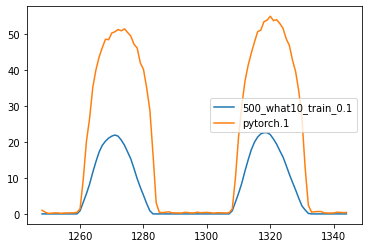

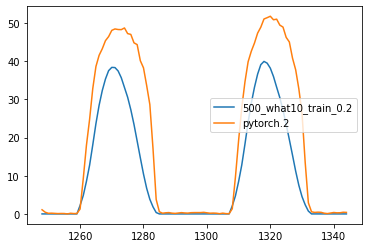

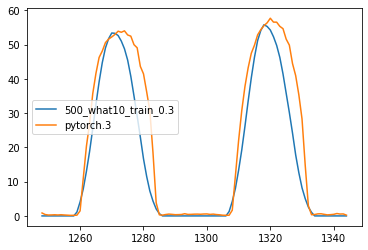

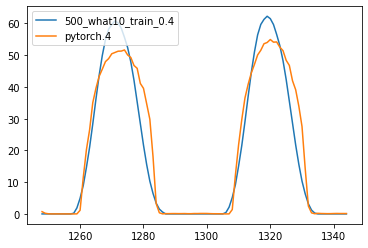

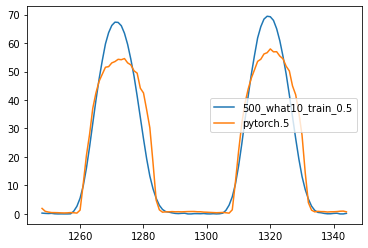

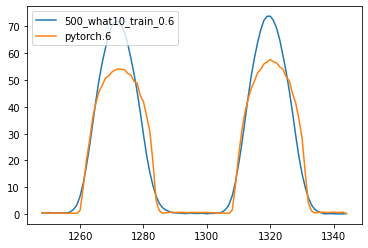

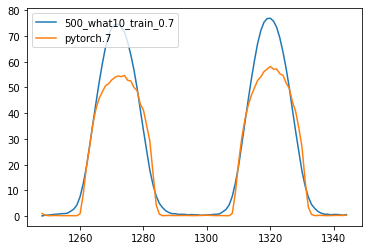

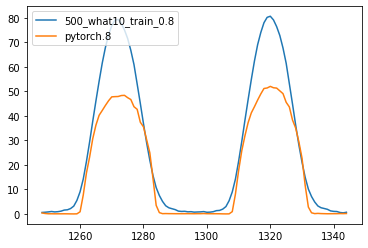

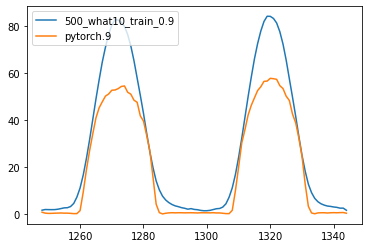

In [ ]:
# 데이터 추정비교
sub1=pd.read_csv(path+"what.csv") # 단일, 학습 10
sub2=pd.read_csv(path+"what1.csv") # 단일, 학습 500, champion , 2.9
sub3=pd.read_csv(path+"what2.csv") # 다중, 학습 500, 3.4
sub4=pd.read_csv(path+"what3.csv") # 다중, 학습 10
sub5=pd.read_csv(path+"what4.csv") # 다중, 학습 100, 3.6 
sub6=pd.read_csv(path+"what5.csv") # 다중, 학습 250
sub7=pd.read_csv(path+"what6.csv") # 다중(GRU+dense), 학습 100
sub8=pd.read_csv(path+"what7.csv") # 다중(GRU+dense), 학습 500
sub9=pd.read_csv(path+"what8.csv") # 다중(LSTM+dense)+시간원핫, 학습 100, 2.7
sub10=pd.read_csv(path+"what9.csv") # 다중(LSTM+dense)+시간원핫, 학습 500, 2.5
sub11=pd.read_csv(path+"what10.csv") # 다중모델2(LSTM+dense)+시간원핫, 학습 1000, 2.4
sub12=pd.read_csv(path+"what11.csv") # 다중모델2(LSTM+dense)+시간원핫, 학습 1000, 테스트 고침
sub13=pd.read_csv(path+"what10이랑 비교해야함.csv") # 다중모델2(LSTM+dense)+시간원핫, 학습 1000, 테스트 고침
sub14=pd.read_csv(path+"seq2seq.csv") # seq2seq, 학습 15, 다중


# 테스트 데이터
test_set_plot_df = test_set_df.copy()
test_set_plot_df[["TARGET"]] = scaler_target.inverse_transform(test_set_plot_df[["TARGET"]])

time_uniut = 13
day = 96
que = day * time_uniut   

s = que
e = s + day

for i in range(1,10):

  #sub1.loc[s:e,f"q_0.{i}"].plot(label=f"10_what_train_0.{i}")
  #sub2.loc[s:e,f"q_0.{i}"].plot(label=f"500_waht1_train_0.{i}")
  #sub3.loc[s:e,f"q_0.{i}"].plot(label=f"500_what2_train_0.{i}")
  #sub4.loc[s:e,f"q_0.{i}"].plot(label=f"10_what3_train_0.{i}")
  #sub5.loc[s:e,f"q_0.{i}"].plot(label=f"100_what4_train_0.{i}")
  #sub6.loc[s:e,f"q_0.{i}"].plot(label=f"250_what5_train_0.{i}")
  #sub7.loc[s:e,f"q_0.{i}"].plot(label=f"100_what6_train_0.{i}")
  #sub8.loc[s:e,f"q_0.{i}"].plot(label=f"500_what7_train_0.{i}")
  #sub9.loc[s:e,f"q_0.{i}"].plot(label=f"100_what8_train_0.{i}")
  #sub10.loc[s:e,f"q_0.{i}"].plot(label=f"500_what9_train_0.{i}")
  sub11.loc[s:e,f"q_0.{i}"].plot(label=f"500_what10_train_0.{i}")
  #sub12.loc[s:e,f"q_0.{i}"].plot(label=f"500_what11_train_0.{i}")
  #sub13.loc[s:e,f"q_0.{i}"].plot(label=f"pare_train_0.{i}")
  sub14.loc[s:e,f"q_0.{i}"].plot(label=f"pytorch.{i}")
  #test_set_plot_df.loc[s:e,"TARGET"].plot(label=f"test_df")

  plt.legend()
  plt.show()